In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pnadcibge_download
import json

sns.set_theme(style="darkgrid")
with open("./RV.json") as f:
    random_variables = json.load(f)

## Auxiliar functions


In [151]:
def plot_dataframe(df: pd.DataFrame, columns: list, format_percentage: bool = False, figsize: tuple = (8, 4)):
    # Se formatar como porcentagem, aplicar em todas as colunas numéricas
    if format_percentage:
        for col in columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].map(lambda x: f"{x:.2f}%")
    
    # Criar a figura
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')

    # Resetar o índice para garantir que a tabela apareça com a numeração adequada
    table_data = df[columns].reset_index(drop=True)

    # Criar a tabela com a função plt.table
    table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"] * len(columns))

    # Exibir a tabela
    plt.show()

## Download and Extract data

In [152]:
# Download o dicionario e o arquivo de dados pnad
dict_paths = pnadcibge_download.download_data(year=2019, trimestre=3)
# Extrai os dados que vem em um zip
dict_paths = pnadcibge_download.extract_data(paths = dict_paths)

Start download data...
Done!
Starting data extraction... 
Done!


## Convert data to pandas Dataframe

In [197]:
# Cria um dataframe com base nos dados extraidos
df = pnadcibge_download.create_dataframe(
    dict_paths, 
    columns_intrested=list(random_variables.keys()), 
    sample_size=0.99,
    random_seed=221704017,
    clear_files = False
    )
df.to_csv("./pnad_3T19.csv", index= False)

## Manipulando dados

In [198]:
# Lendo o dataframe original
df_original: pd.DataFrame = pd.read_csv("./pnad_3T19.csv")
print(f"Dataframe lido tem {len(df_original)} linhas.")

# Rename columns
dict_col_names = {k: v.get("col_name") for k, v in random_variables.items()}
df_original = df_original.rename(columns = dict_col_names)

# Limpando colunas nulas
df_limpo = df_original.dropna()
print(f"Dataframe dropped na rows tem {len(df_limpo)} linhas")

Dataframe lido tem 544725 linhas.
Dataframe dropped na rows tem 199013 linhas


In [187]:
mask_age = (df_limpo["CON_IDADE"] >= 20) & (df_limpo["CON_IDADE"] <= 60)
df_economicamente_ativos = df_limpo[mask_age]

### Proporções população economicamente ativa

#### Vs nível de formação

Valores ORD_NIVEL_FORMACAO:
- 02: Pré-escola
- 03: Classe de alfabetização - CA
- 04: Alfabetização de jovens e adultos
- 05: Antigo primário (elementar)
- 06: Antigo ginásio (médio 1º ciclo)
- 07: Regular do ensino fundamental ou do 1º grau
- 08: Educação de jovens e adultos (EJA) ou supletivo do 1º grau
- 09: Antigo científico, clássico, etc. (médio 2º ciclo)
- 10: Regular do ensino médio ou do 2º grau
- 11: Educação de jovens e adultos (EJA) ou supletivo do 2º grau
- 12: Superior - graduação
- 13: Especialização de nível superior
- 14: Mestrado
- 15: Doutorado

/tmp/ipykernel_66918/276094389.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nv_formacao["ORD_NIVEL_FORMACAO"] = df_nv_formacao["ORD_NIVEL_FORMACAO"].replace(dict_niveis_formacao)
/tmp/ipykernel_66918/276094389.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nv_formacao["ORD_NIVEL_FORMACAO"] = pd.Categorical(df_nv_formacao["ORD_NIVEL_FORMACAO"],


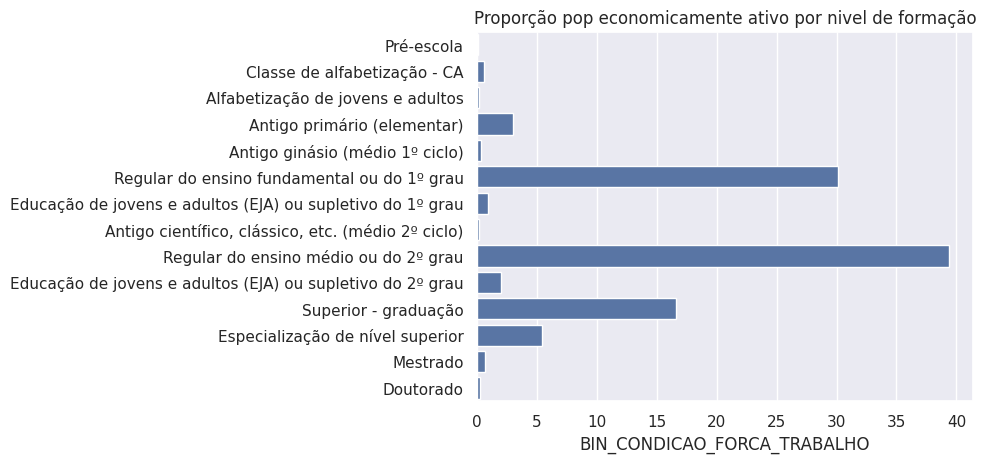

In [188]:
dict_niveis_formacao = {
    2:	"Pré-escola",
    3:	"Classe de alfabetização - CA",
    4:	"Alfabetização de jovens e adultos",
    5:	"Antigo primário (elementar)",
    6:	"Antigo ginásio (médio 1º ciclo)",
    7:	"Regular do ensino fundamental ou do 1º grau",
    8:	"Educação de jovens e adultos (EJA) ou supletivo do 1º grau",
    9:	"Antigo científico, clássico, etc. (médio 2º ciclo)",
    10:	"Regular do ensino médio ou do 2º grau",
    11:	"Educação de jovens e adultos (EJA) ou supletivo do 2º grau",
    12:	"Superior - graduação",
    13:	"Especialização de nível superior",
    14:	"Mestrado",
    15:	"Doutorado",
}
df_nv_formacao = df_economicamente_ativos[["ORD_NIVEL_FORMACAO", "BIN_CONDICAO_FORCA_TRABALHO"]]
df_nv_formacao["ORD_NIVEL_FORMACAO"] = df_nv_formacao["ORD_NIVEL_FORMACAO"].replace(dict_niveis_formacao)
ordem_categorica = list(dict_niveis_formacao.values())


# Converter para uma categoria ordenada
df_nv_formacao["ORD_NIVEL_FORMACAO"] = pd.Categorical(df_nv_formacao["ORD_NIVEL_FORMACAO"], 
                                                      categories=ordem_categorica, 
                                                      ordered=True)

sns.barplot(data = df_nv_formacao, 
            y="ORD_NIVEL_FORMACAO", 
            x="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="h",
            estimator = lambda x: x.sum() * 100/ len(df_economicamente_ativos))
plt.title("Proporção pop economicamente ativo por nivel de formação")
plt.ylabel(ylabel=None)
plt.show()

/tmp/ipykernel_66918/2305587418.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tabela = df_nv_formacao.groupby("ORD_NIVEL_FORMACAO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()


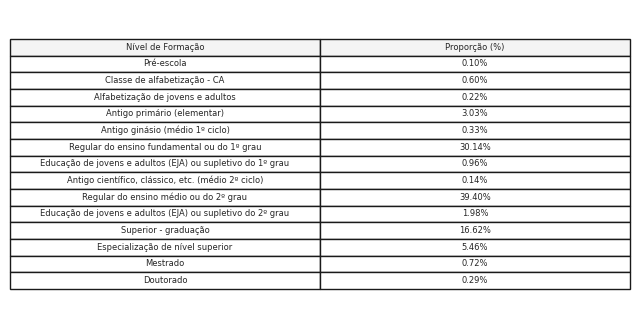

In [189]:
df_tabela = df_nv_formacao.groupby("ORD_NIVEL_FORMACAO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()
df_tabela = (df_tabela / df_tabela.sum()) * 100
df_tabela = df_tabela.map(lambda x: f"{x:.2f}%")

# Criar a figura
fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela no gráfico
table_data = df_tabela.reset_index()
table_data.columns = ['Nível de Formação', 'Proporção (%)']  # Adicionar rótulos às colunas

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"]*2)

# Exibir a tabela
plt.show()

#### Vs Idade

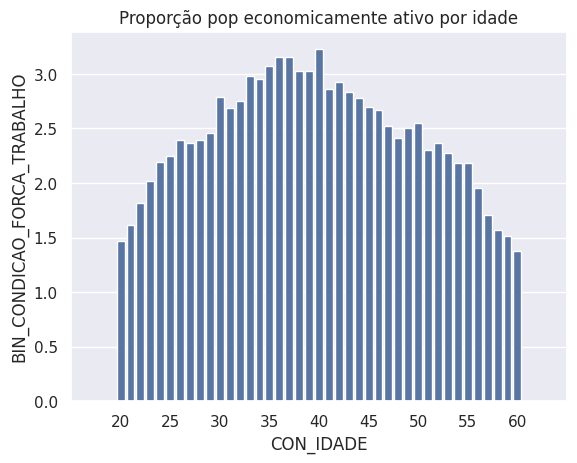

In [190]:
sns.barplot(data = df_economicamente_ativos, 
            x="CON_IDADE", 
            y="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="v",
            estimator = lambda x: x.sum() * 100/ len(df_economicamente_ativos))
plt.title("Proporção pop economicamente ativo por idade")
plt.xlim(0, 41)

plt.xticks(range(-5, 50, 5))
plt.show()

/tmp/ipykernel_66918/266947916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_economicamente_ativos["FAIXA_IDADE"] = faixas_idade
/tmp/ipykernel_66918/266947916.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tabela = df_economicamente_ativos.groupby("FAIXA_IDADE")["BIN_CONDICAO_FORCA_TRABALHO"].sum()


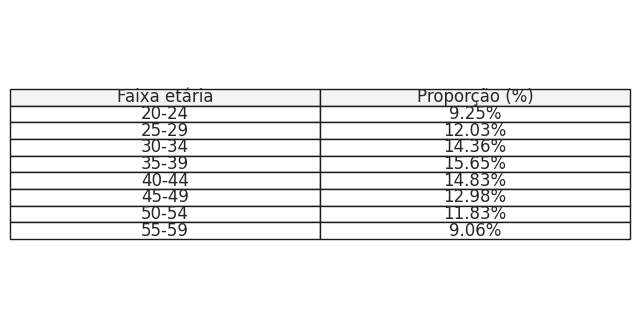

In [191]:
# Criar faixas de 5 em 5 anos para a coluna CON_IDADE
faixas_idade = pd.cut(df_economicamente_ativos["CON_IDADE"], 
                      bins=range(20, 65, 5),  # Definindo as faixas de 5 em 5 anos (20 a 60)
                      right=False,  # Para incluir a faixa inicial, mas não a final
                      labels=[f"{i}-{i+4}" for i in range(20, 60, 5)])

# Adicionar a coluna de faixas de idade ao DataFrame
df_economicamente_ativos["FAIXA_IDADE"] = faixas_idade

# Agrupar por faixa de idade e calcular a soma de BIN_CONDICAO_FORCA_TRABALHO
df_tabela = df_economicamente_ativos.groupby("FAIXA_IDADE")["BIN_CONDICAO_FORCA_TRABALHO"].sum()

# Converter para porcentagem
df_tabela = (df_tabela / df_tabela.sum()) * 100

# Formatar os valores como porcentagem
df_tabela = df_tabela.map(lambda x: f"{x:.2f}%")

fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela no gráfico
table_data = df_tabela.reset_index()
table_data.columns = ['Faixa etária', 'Proporção (%)']  # Adicionar rótulos às colunas

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"]*2)

# Exibir a tabela
plt.show()

#### Vs Sexo

/tmp/ipykernel_66918/4238431022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_economicamente_sexo.loc["BIN_SEXO"] = df_economicamente_sexo["BIN_SEXO"].replace(dict_replace_sexo)


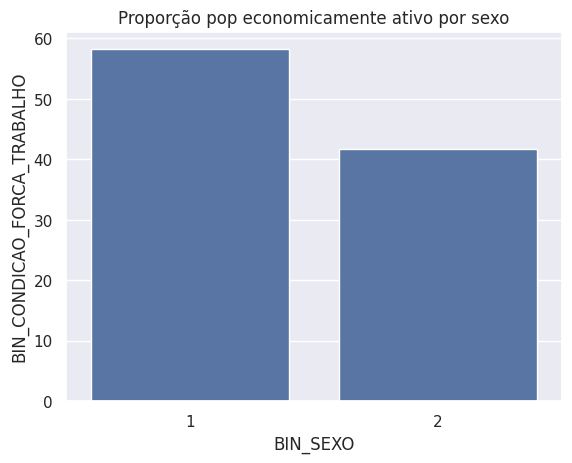

In [192]:
dict_replace_sexo = {
    1: "Homem",
    2: "Mulher"
}

df_economicamente_sexo = df_economicamente_ativos[["BIN_SEXO", "BIN_CONDICAO_FORCA_TRABALHO"]]
df_economicamente_sexo.loc["BIN_SEXO"] = df_economicamente_sexo["BIN_SEXO"].replace(dict_replace_sexo)

sns.barplot(data = df_economicamente_ativos, 
            x="BIN_SEXO", 
            y="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="v",
            estimator = lambda x: x.sum() * 100/ len(df_economicamente_ativos))
plt.title("Proporção pop economicamente ativo por sexo")
plt.show()

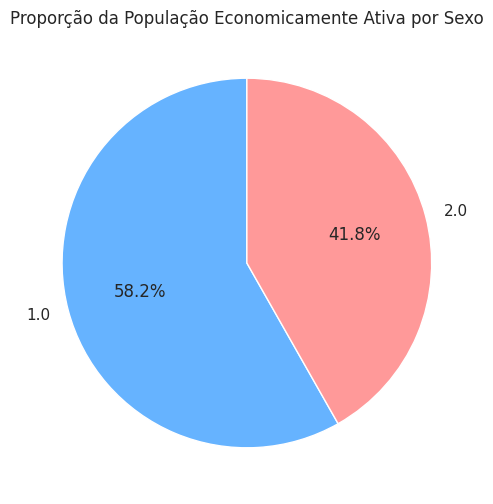

In [193]:
proporcoes = df_economicamente_sexo.groupby("BIN_SEXO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()
proporcoes = proporcoes * 100 / len(df_economicamente_sexo)  # Converter para porcentagem

# Criar o gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(proporcoes, labels=proporcoes.index, autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"], startangle=90)
plt.title("Proporção da População Economicamente Ativa por Sexo")

plt.show()

### Estatísticas variáveis contínuas 

Coluna **NOM_MODO_TRABALHO**
- 1: Trabalhador doméstico
- 2: Militar do exército, da marinha, da aeronáutica, da polícia militar ou do corpo de bombeiros militar
- 3: Empregado do setor privado
- 4: Empregado do setor público (inclusive empresas de economia mista)
- 5: Empregador
- 6: Conta própria
- 7: Trabalhador familiar não remunerado

In [199]:
mask_setor_privado = df_limpo["NOM_MODO_TRABALHO"] == 3
mask_empregados = df_limpo["BIN_CONDICAO_OCUPACAO"] == 1
df_setor_privado = df_limpo
col_rvs_continuas = list()
col_rvs_discretas = list()
for col in df_setor_privado.columns: 
    if col.startswith("CON_"):
        col_rvs_continuas.append(col)
    else:
        col_rvs_discretas.append(col)


##### Descrição RVS continuas

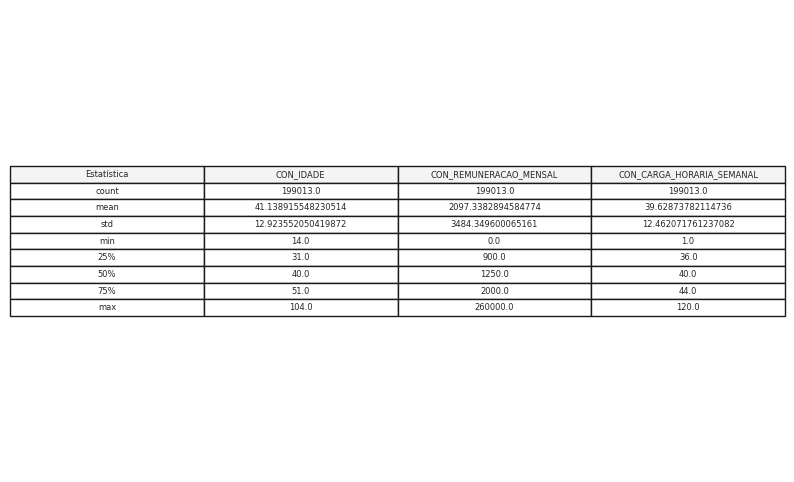

In [200]:

df_description_continue_rvs = df_setor_privado[col_rvs_continuas].describe()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela com a função plt.table
table_data = df_description_continue_rvs.reset_index()
table_data.columns = ['Estatística'] + list(df_description_continue_rvs.columns)

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"] * len(table_data.columns))

# Salvar como imagem
plt.savefig("tabela_describe.png", bbox_inches='tight', dpi=300)

# Exibir a tabela
plt.show()

##### Descrição RVS Discretas

In [201]:
for col in col_rvs_discretas:
    description_discrete_rv = df_setor_privado[col].value_counts(normalize=True) * 100
    print(description_discrete_rv)

NOM_UF
35    9.341098
31    8.247200
33    7.562320
42    7.025672
43    6.025235
41    5.988051
23    4.781597
21    4.778582
32    4.200228
29    4.182641
52    3.929894
15    3.408320
26    3.367619
51    2.815896
27    2.570184
13    2.564657
50    2.539533
25    2.281760
22    2.088306
53    2.070217
24    1.842593
28    1.771744
11    1.726520
12    1.537086
17    1.414983
14    1.068272
16    0.869792
Name: proportion, dtype: float64
BIN_ZONA_DOMICILIO
1    77.473833
2    22.526167
Name: proportion, dtype: float64
BIN_SEXO
1    59.072523
2    40.927477
Name: proportion, dtype: float64
NOM_ETNIA
4    48.378749
1    41.405335
2     9.200906
3     0.566797
5     0.437660
9     0.010552
Name: proportion, dtype: float64
ORD_NIVEL_FORMACAO
10.0    38.081432
7.0     28.814701
12.0    15.970313
5.0      5.399145
13.0     5.269505
11.0     1.908418
8.0      0.981343
6.0      0.804973
3.0      0.779849
14.0     0.731610
9.0      0.547703
15.0     0.299478
4.0      0.294453
2.0      0.1170